![Pytorch logo](./images/logo.png)

In a previous workshop, you learned how to use Numpy to simply manage matrices in Python.
In order to make the creation of neural networks easier and faster, we will learn to use Pytorch, a library created by Meta AI.

Let's start by importing the libraries we will need!
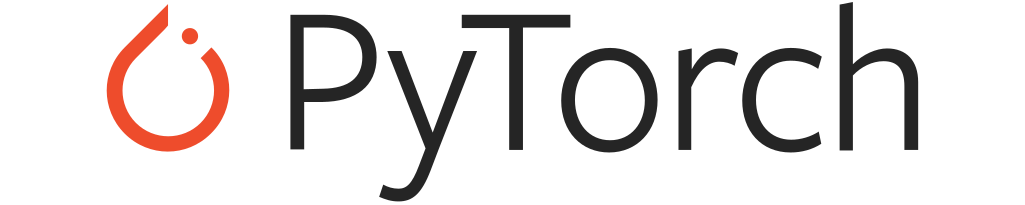

In [2]:
import numpy as np

import torch
from torch import nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

import sklearn
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

## 1. Tensors

Pytorch makes it very easy to use the GPU to perform matrix calculations more quickly without having to write additional code.
Pytorch proposes an overlay to the Numpy arrays called Tensor. More simply, a Pytorch tensor is a Numpy matrix whose operations can be calculated on the GPU.

You can find out more about tensors by following this link: [Pytorch Tensors](https://pytorch.org/tutorials/beginner/introyt/tensors_deeper_tutorial.html)

Let's create our first tensor !

In [4]:
# Create a Tensor filled with 0 (we can also create a tensor filled with 1 using torch.ones())
x = torch.zeros(2)

print(x)
print(x.shape)

assert x.max() == 0 and x.min() == 0
print('=> Test passed :)')

tensor([0., 0.])
torch.Size([2])
=> Test passed :)


In [15]:
# Create a Tensor filled with random values (between 0 and 1)
y = torch.rand(1, 5)
print(y)
print(y.shape)

assert y.min() >= 0 and y.max() <= 1
print('=> Test passed :)')

tensor([[0.0266, 0.7812, 0.0256, 0.1966, 0.1696]])
torch.Size([1, 5])
=> Test passed :)


In [16]:
# We can apply arithmetics operations on tensors

print(y)
print(y + 1)
print(y * 3)

tensor([[0.0266, 0.7812, 0.0256, 0.1966, 0.1696]])
tensor([[1.0266, 1.7812, 1.0256, 1.1966, 1.1696]])
tensor([[0.0798, 2.3437, 0.0768, 0.5899, 0.5089]])


There are many other operations that can be applied to tensors but we won't need them here.

## 2. First Neural Network

Let's create our first neural network. In PyTorch, our model is broken down into modules, knowing that each module can contain several others.
Let's define our first module with the set of operations it will have to perform.

More informations about [Pytorch Modules](https://pytorch.org/docs/stable/notes/modules.html)

We will define our first module and several functions that we will use in our model. Pytorch already integrates many useful functions in AI optimized for Tensor.

![image.png](./images/nn.png)
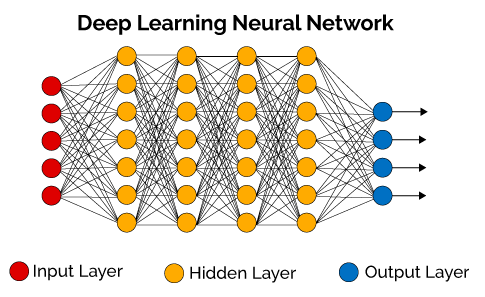

Let's begin by building a model with two [linear layers](https://pytorch.org/docs/stable/nn.html#linear-layers):

In [34]:
class Network(nn.Module):

    """
    We define all operations and parameters of the network.
    """
    def __init__(self, label_count):
        super(Network, self).__init__()
        
        # Create two linear layers (2 inputs, 50 neurons in hidden layer, [label_count] outputs)
        self.linear1 = None
        self.linear2 = None    


    """
    The function applies the forward of the model, i.e. it transforms the input into a prediction.

    All the operations of the model will be applied successively to our data.
    """
    def forward(self, input):
        # Apply first linear transformation
        output = self.linear1(input)
        # Apply activation function
        output = F.relu(output)
        
        # Apply second linear transformation
        output = self.linear2(output)

        return output
    
    """
    This function will be used to predict the label of our input.
    """
    def predict(self, input):
        # Apply activation function
        output = F.relu(self.forward(input))

        # Retrieve the highest probability from the output data
        _, predicted = torch.max(output.data, 1)
        return predicted

In [55]:
EPOCH = 100
LEARNING_RATE = 0.005
CLASSES = 2

network = Network(label_count=CLASSES).to("cpu")

# choose a loss function (for example Cross Entropy)
criterion = torch.nn.BCEWithLogitsLoss(reduction='sum')
# choose an optimizer (for example Adam): pay attention to the documentation
optimizer = torch.optim.Adam(params=network.parameters(), lr=LEARNING_RATE)

ValueError: optimizer got an empty parameter list

Criterion will be used to calculate the loss between the result obtained and the expected result of the network:  [CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html?highlight=crossentropy#torch.nn.CrossEntropyLoss)   
Optimizer will be used to modify our network to get closer to the expected result: [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html)  

There are many other optimizers algorithms and loss functions, you can choose the one that best fits your data with the help of this documentation:
  - [Ultimate guide to PyTorch optimizers](https://analyticsindiamag.com/ultimate-guide-to-pytorch-optimizers/)
  - [PyTorch - Optimisation algorithms](https://pytorch.org/docs/stable/optim.html#algorithms)
  - [PyTorch - Loss functions](https://pytorch.org/docs/stable/nn.html#loss-functions)

## 3. Data

For this workshop, we will use fairly simple data so that everyone can understand.   
Let's use `sklearn`'s [`make_blobs()`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html#sklearn.datasets.make_blobs) function to generate 200 samples of data with 2 features and [`CLASSES`] centers. 

Data shapes: (x, y):
torch.Size([100, 2]) torch.Size([100])


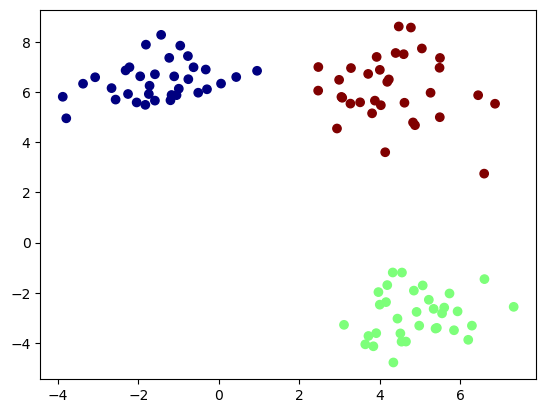

In [56]:
# use `make_blobs()` to generate data
X, Y = sklearn.datasets.make_blobs()

# In order to use our data with Pytorch, we will have to load them into a Tensor.
x = torch.from_numpy(X.astype(np.float32))
y = torch.from_numpy(Y.astype(np.int64))

print("Data shapes: (x, y):")
print(x.shape, y.shape)

plt.scatter(x[:, 0], x[:, 1], c=y,cmap='jet')
plt.show()

#### Now, let's split the data in a training set and a testing set:

The training set will be used for training our model and the testing set will be used to make sure the model isn't overfitting.

`sklearn` has a very useful function for this process: [`train_test_split()`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)

In [58]:
# use the train_test_split() function
x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(X, Y)

print("Train / Test split shapes: (x_train, x_test, y_train, y_test): ")
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

Train / Test split shapes: (x_train, x_test, y_train, y_test): 
(75, 2) (25, 2) (75,) (25,)


## 4. Training

Now it's time to train our model! At the moment, our model is making random predictions (which is already a good start, it means that our data is getting through).  
  
We will collect the loss and accuracy of each epoch to see if our network improves its predictions or if there is a problem.

In [62]:
loss_history = np.zeros(EPOCH)
train_accuracy_history = np.zeros(EPOCH)
test_accuracy_history = np.zeros(EPOCH)

for epoch in range(EPOCH):
    # Reset gradiants
    optimizer.zero_grad()
    # Forward
    output = network.forward(x_train)
    # Compute loss
    loss = criterion(output, y_train)
    # Compute gradiants: ~ 1 line of code
    loss.backward()
    # Apply gradiants: ~ 1 line of code
    optimizer.step()
    # Monitoring
    loss_history[epoch] = loss.item()
    train_accuracy_history[epoch] = accuracy_score(network.predict(x_train),y_train)
    test_accuracy_history[epoch] = accuracy_score(network.predict(x_test),y_test)
    if (epoch % 10 == 0):
        print("Epoch {} - Loss {} - Accuracy {}".format(epoch, loss.item(), accuracy_score(network.predict(x_train),y_train)))


NameError: name 'optimizer' is not defined

We are going to use matplotlib (a library allowing to draw graphs) in order to visualize more simply the measurements made during the training.

Feel free to visit [Matplotlib documentation](https://matplotlib.org/stable/tutorials/introductory/usage.html) if you want more informations.

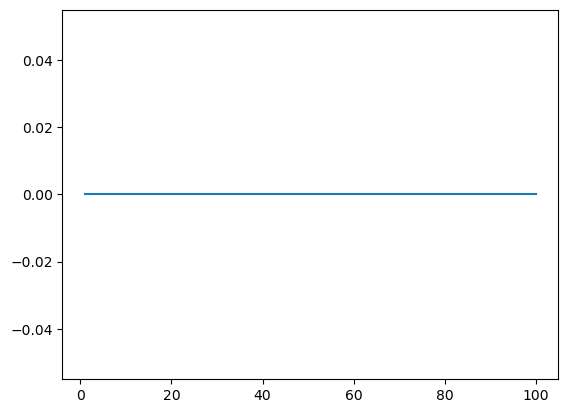

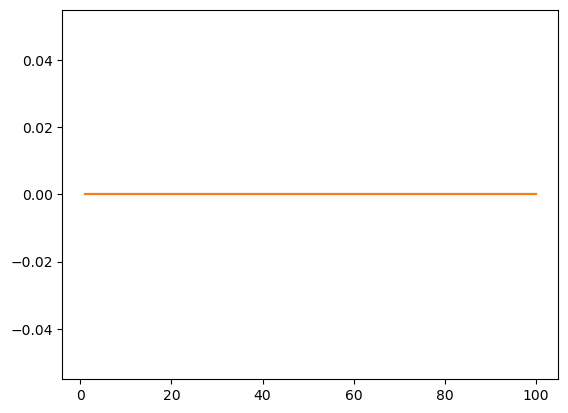

In [63]:
plt.plot(np.arange(1, EPOCH + 1), loss_history)
plt.show()

plt.plot(np.arange(1, EPOCH + 1), train_accuracy_history)
plt.plot(np.arange(1, EPOCH + 1), test_accuracy_history)
plt.show()

# Conclusion

Finally, let's draw a decision boundary to demonstrate how smart our model is:

In [64]:
def predict(x):
    x = torch.from_numpy(x).type(torch.FloatTensor)
    ans = network.predict(x)
    return ans.numpy()

def draw_decision_boundary(X,y):
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    xx,yy=np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.binary)

draw_decision_boundary(x,y)

TypeError: 'NoneType' object is not callable

## 5. It's your turn!

To access the second part of this workshop we invite you to open the second Jupyter Notebook *exercise.ipynb*